## Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models
import scalib.utils as utils
import scalib.eda as eda
import scalib.cfg as cfg

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
print('Parent working directory: %s' % utils.cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/scalib


## Import training dataset

In [2]:
# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import Kelvins dataset and convert it to dataframes in CCSDS format
for filename in ['test_data.csv', 'train_data.csv']:

    filepath_dest = os.path.join(utils.cwd,'data','ccsds', filename)
    filepath_orig = os.path.join(utils.cwd,'data','esa-challenge', filename)

    if os.path.exists(filepath_dest):
        df = pd.read_csv(filepath_dest, index_col=0)
    else:

        # Get ConjunctionEventsDataset object 
        events = kelvins_challenge_events(filepath_orig,
                    drop_features = ['c_rcs_estimate', 't_rcs_estimate'])

        # Convert Conjunction Events Dataset to pandas DataFrame and save it.
        df = events.to_dataframe(event_id=True)
        df.to_csv(filepath_dest)
        
display(df.head(5))

,CCSDS_CDM_VERS,CREATION_DATE,ORIGINATOR,MESSAGE_FOR,MESSAGE_ID,TCA,MISS_DISTANCE,RELATIVE_SPEED,RELATIVE_POSITION_R,RELATIVE_POSITION_T,...,OBJECT2_CTHR_NDOT,OBJECT2_CTHR_DRG,OBJECT2_CTHR_SRP,OBJECT2_CTHR_THR,__MAX_RISK_ESTIMATE,__MAX_RISK_SCALING,__CREATION_DATE,__TCA,__DAYS_TO_TCA,__EVENT_ID
0,1.0,2023-09-20T07:30:55.604684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14923.0,13792.0,453.8,5976.6,...,NaN,NaN,NaN,NaN,-7.834756,8.602101,0.000000,1.566798,1.566798,0
1,1.0,2023-09-20T16:08:19.532684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14544.0,13792.0,474.3,5821.2,...,NaN,NaN,NaN,NaN,-7.848937,8.956374,0.359305,1.566798,1.207494,0
2,1.0,2023-09-20T22:15:57.518684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14475.0,13792.0,474.6,5796.2,...,NaN,NaN,NaN,NaN,-7.847406,8.932195,0.614605,1.566798,0.952193,0
3,1.0,2023-09-21T07:12:23.538684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14579.0,13792.0,472.7,5838.9,...,NaN,NaN,NaN,NaN,-7.845880,8.913444,0.987129,1.566798,0.579669,0
4,1.0,2023-09-21T14:55:52.529684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14510.0,13792.0,478.7,5811.1,...,NaN,NaN,NaN,NaN,-7.852942,9.036838,1.308992,1.566798,0.257806,0


In [3]:
# Cast columns as correct dtypes
convert_dict = dict()

# Iterate over all objects
for o in [1, 2]:

    # Iterate over all features in a CDM
    for feature, information in cfg.cdm_features.items():

        # Get the cluster of the CDM data.
        cluster = information['cluster']

        if (cluster.startswith('header') or cluster.startswith('relative')) and o==1:
             xfeature = feature
        elif not (cluster.startswith('header') or cluster.startswith('relative')):
            xfeature = f'OBJECT{o}_{feature}'

        if xfeature in convert_dict.keys(): continue
        #if xfeature not in df.columns: continue
        convert_dict[xfeature] = information['dtype']

df = df.astype(convert_dict)


In [4]:
reload(cfg)
# Get list of obligatory features.
features = cfg.get_features(only_names=True,include_object_preffix=True, 
                            **dict(obligatory=True, cluster='data_covariance'))

# Segregate numerical from categorical features
#cat_features = [f for f in features if df[f].dtype=='category']
cat_features=['OBJECT1_OBJECT_TYPE', 'OBJECT2_OBJECT_TYPE']

num_features = [f for f in features if f in df._get_numeric_data().columns]
num_features.append('__DAYS_TO_TCA')
out_features = ['COLLISION_PROBABILITY']

features = features + ['COLLISION_PROBABILITY', '__MAX_RISK_ESTIMATE', '__MAX_RISK_SCALING']
df_ann = df[out_features + num_features + cat_features]

display(df_ann.head(5))
display(df_ann.describe())

# print(f'Output features:\n' + utils.tabular_list(out_features, n_cols=3, col_sep = ' - '))
# print(f'Input Categorical features:\n' + utils.tabular_list(cat_features, n_cols=3, col_sep = ' - '))
# print(f'Input Continuous features:\n' + utils.tabular_list(con_features, n_cols=3, col_sep = ' - '))

,COLLISION_PROBABILITY,OBJECT1_CR_R,OBJECT2_CR_R,OBJECT1_CT_R,OBJECT2_CT_R,OBJECT1_CT_T,OBJECT2_CT_T,OBJECT1_CN_R,OBJECT2_CN_R,OBJECT1_CN_T,...,OBJECT2_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT2_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT2_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT2_CNDOT_NDOT,__DAYS_TO_TCA,OBJECT1_OBJECT_TYPE,OBJECT2_OBJECT_TYPE
0,-10.204955,16.466810,71140.79,-222.242200,-11961160.0,18938.4700,2.955756e+09,2.112694,5892.756,10.002140,...,13.00946,9.316645e-07,-4.434362,-0.000002,-0.042638,0.000009,0.149353,1.566798,PAYLOAD,UNKNOWN
1,-10.355758,12.438180,68744.55,-14.462720,-11602080.0,3143.8580,2.924870e+09,1.888744,5897.834,6.113387,...,12.99737,-9.040335e-07,-4.390144,-0.000002,-0.042872,0.000009,0.149300,1.207494,PAYLOAD,UNKNOWN
2,-10.345631,11.303290,68469.38,-13.770550,-11555830.0,1406.0960,2.918959e+09,1.869411,5898.712,2.986285,...,12.99521,-2.763477e-06,-4.381993,-0.000001,-0.042886,0.000009,0.149290,0.952193,PAYLOAD,UNKNOWN
3,-10.337809,9.460428,68518.15,1.476252,-11579220.0,494.3005,2.927633e+09,2.380359,5899.596,6.398545,...,12.99755,-3.218169e-06,-4.394314,-0.000002,-0.042897,0.000009,0.149305,0.579669,PAYLOAD,UNKNOWN
4,-10.391260,11.506860,67978.79,22.836610,-11501960.0,259.5581,2.922881e+09,2.697022,5901.675,7.789963,...,12.99492,-6.967915e-06,-4.387243,-0.000003,-0.042947,0.000010,0.149296,0.257806,PAYLOAD,UNKNOWN


,COLLISION_PROBABILITY,OBJECT1_CR_R,OBJECT2_CR_R,OBJECT1_CT_R,OBJECT2_CT_R,OBJECT1_CT_T,OBJECT2_CT_T,OBJECT1_CN_R,OBJECT2_CN_R,OBJECT1_CN_T,...,OBJECT2_CNDOT_T,OBJECT1_CNDOT_N,OBJECT2_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT2_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT2_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT2_CNDOT_NDOT,__DAYS_TO_TCA
count,127037.000000,127037.000000,127037.000000,127037.000000,1.270370e+05,1.270370e+05,1.270370e+05,127037.000000,127037.000000,127037.000000,...,127037.000000,127037.000000,127037.000000,1.270370e+05,127037.000000,1.270370e+05,127037.000000,1.270370e+05,127037.000000,127037.000000
mean,-20.182834,35.908156,35337.640692,-161.193973,-5.336295e+05,6.413597e+04,2.983188e+08,2.048410,1397.369264,-0.298369,...,-18.861943,0.002860,8.147357,8.414212e-08,0.016910,-1.652280e-06,-0.007410,1.775709e-05,0.059481,3.233928
std,10.048709,47.214457,99302.366104,1021.840070,4.703970e+06,2.787267e+05,1.002829e+09,6.624918,21501.546569,68.966087,...,1366.346422,0.008620,49.435199,1.662945e-04,1.399574,9.021418e-06,0.065199,2.621128e-05,0.346754,1.998297
min,-30.000000,0.489294,0.979248,-33897.670017,-9.724996e+07,6.751638e+00,2.476385e+01,-114.030710,-296147.602180,-3854.640162,...,-84097.108281,-0.278727,-598.965953,-1.731301e-02,-27.846360,-2.793286e-04,-1.867386,9.338203e-07,0.000002,-0.149808
25%,-30.000000,8.801788,755.641200,-91.204460,-1.941400e+05,8.281851e+02,7.399137e+05,0.019425,-196.835944,-5.417089,...,-18.637033,-0.000342,-0.033137,-8.001356e-06,-0.016701,-2.806627e-06,-0.002946,7.346501e-06,0.000723,1.483597
50%,-22.846185,20.032789,3531.500184,-15.135134,-1.206874e+04,5.102538e+03,9.963152e+06,1.174872,62.336851,0.007857,...,-0.001395,0.001842,0.273539,3.053044e-08,0.000008,-8.892520e-07,-0.000225,1.118877e-05,0.003470,3.127263
75%,-9.646084,44.341040,19450.890000,6.497921,7.550018e+02,2.458334e+04,9.863982e+07,3.665642,1309.808000,4.920443,...,15.755460,0.004218,3.522144,7.638839e-06,0.020216,2.540593e-07,0.000075,1.713301e-05,0.018044,4.922865
max,-1.442854,399.896163,999653.817275,36646.610000,9.537125e+07,3.998408e+06,9.997002e+09,102.910689,344779.700000,7617.330916,...,32678.080000,0.211840,1107.883000,2.422636e-02,83.183784,8.555327e-04,2.558004,2.220647e-03,21.840158,6.993832


## Aritificial Neural Network model for Collision Risk Probability Estimation (CRPE)

#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [6]:
# Set overall seed for reproducibility
utils.seed(1)

# Get Torch for output features
y = np.stack([df[f].to_numpy() for f in out_features], 1)
y = torch.tensor(y, dtype=torch.float, requires_grad=True) 

# Get Torch for all continuous features
nums = np.stack([df[f].to_numpy() for f in num_features], 1)
nums = torch.nan_to_num(torch.tensor(nums, dtype=torch.float, requires_grad=True))

# Normalise continuous variables
bn_nums = nn.BatchNorm1d(len(num_features))
X_num = bn_nums(nums)

# Get Torch for all categorical features
cats = np.stack([df[f].cat.codes.values for f in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int)

# This will set embedding sizes for the categorical columns:
# an embedding size is the length of the array into which every category
# is converted
cat_szs = [len(df[f].cat.categories) for f in cat_features]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

# Initialize list of embedding operations.
#  - nuv = Number of unique vectors
#  - nvc = Number of vector componets
embeddings = nn.ModuleList([nn.Embedding(nuv, nvc) for nuv, nvc in emb_szs])

# Initialize embeddings list
embeddings_tensors = []

# Apply embedding operation to every column of categorical tensor
for i, embedding in enumerate(embeddings):
    #print(cats[:,i])
    embeddings_tensors.append(embedding(cats[:,i]))

# Concatenate embedding sections into 1
X_cat = torch.cat(embeddings_tensors, 1)
    
# Concatenate embeddings with continuous variables into one torch
X = torch.cat([X_cat, X_num], 1)

# Create dataset object with the inputs and targets
data = xnn.Data(X, y)
data_train, data_test = data.split()

### Initialize CollisionRisk model

In [21]:
# Initialise input and output sizes
input_size = data.inputs.size(1)
output_size = data.outputs.size(1)

layers=[input_size*4, input_size*2, input_size]
p = 0.2

# Run through every layer to set up the operations to perform per layer.
# (i.e. layers=[100, 200, 100])

# Initialise network list
network = nn.ModuleList()
input_neurons = input_size
for l, hidden_neurons in enumerate(layers):
    # On layer l, which contains n_neurons, perform the following 
    # operations:
    # 1. Apply Linear neural network model regression (fully connected 
    # network -> z = Sum(wi*xi+bi))
    network.append(nn.Linear(input_neurons, hidden_neurons))
    
    # 2. Apply ReLU activation function (al(z))
    network.append(nn.ReLU())
    
    # 3. Normalize data using the n_neurons
    network.append(nn.BatchNorm1d(hidden_neurons))
    
    # 4. Cancel out a random proportion p of the neurons to avoid 
    # overfitting
    network.append(nn.Dropout(p))
    
    # 5. Set new number of input features n_in for the next layer l+1.
    input_neurons = hidden_neurons

# Set the last layer of the list which corresponds to the final output
network.append(nn.Linear(layers[-1], output_size))

# Get filepath for the model and print it  
filename = 'crpe'
for l in layers:
    filename = f'{filename}_l{l}'
filepath = os.path.join(utils.cwd, 'models', f'{filename}_parameters.pt')
print(filepath)

/Users/jjrr/Documents/SCA-Project/scalib/models/crpe_l188_l94_l47_parameters.pt


In [22]:
model = xnn.CollisionRiskProbabilityEstimator(input_size = X.size(1), 
                     output_size = y.size(1), 
                     network = network)

print(model)

CollisionRiskProbabilityEstimator(
  (model): ModuleList(
    (0): Linear(in_features=47, out_features=188, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(188, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=188, out_features=94, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(94, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=94, out_features=47, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(47, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=47, out_features=1, bias=True)
  )
)


In [59]:
model.learn(data=data_train, epochs=5, lr=1e-3, batch_size=1000, device='cpu', 
            epoch_step_checkpoint=2, filepath=filepath)

Number of learnable parameters of the model: 31,961

Model parameters loaded from /Users/jjrr/Documents/SCA-Project/scalib/models/crpe_l188_l94_l47_parameters.pt
 - Total epochs       = 5
 - Total iterations   = 435
 - Validation loss    = 1.5419e+02
 - Last learning rate = 1.0000e-03


TRAINING COLLISION RISK PROBABILITY ESTIMATOR MODEL:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (435/435)| 00h:28m:03s |   0.26    | E(5/5) B(87/87) | Loss > T(5.6447e+01) V(5.5840e+01)

Saving model parameters ... Done.


              0
1    504.764557
2    504.764557
3    504.764557
4    504.764557
5    504.764557
..          ...
866   55.839825
867   55.839825
868   55.839825
869   55.839825
870   55.839825

[870 rows x 1 columns]


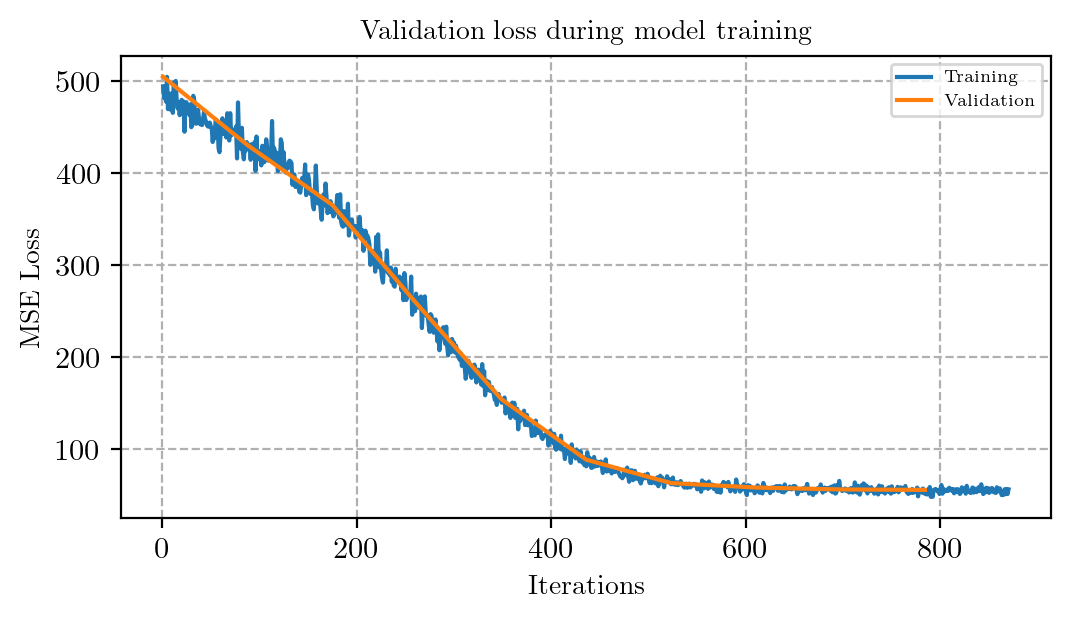

In [62]:
results = model._learn_results  
data_training = pd.Series(results['training_loss'], results['total_iterations'])
data_validation = pd.DataFrame(results['validation_loss'], results['total_iterations'])

print(data_validation)

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(data_training.drop_duplicates(keep='first'), label='Training')
ax.plot(data_validation.drop_duplicates(keep='first'), label='Validation')

ax.set_title('Validation loss during model training', fontsize=10)
ax.set_xlabel('Iterations', fontsize=10)
ax.set_ylabel('MSE Loss', fontsize=10)
#ax.set_ylim(0,0.3)
#ax.set_xlim(1, 5)
ax.legend(fontsize=6, loc='best')#, bbox_to_anchor=(1, 0.5)
ax.grid(True, linestyle='--')
# fig.savefig(filepath, bbox_inches='tight')

## Model evaluation

In [63]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.metrics import f1_score as f1, recall_score as recall

# Define risk threshold for collision avoidance manouvre.
risk_threshold = -4.0


y_pred = model.forward(data_test.inputs).detach().numpy().flatten()
y_true = data_test.outputs.detach().numpy().flatten()

df_val = pd.DataFrame()
df_val['pred_risk'] = y_pred
df_val['true_risk'] = y_true
df_val['diff_risk'] = np.abs(df_val['pred_risk'] - df_val['true_risk'])
df_val['pred_flag'] = df_val['pred_risk']>=risk_threshold
df_val['true_flag'] = df_val['true_risk']>=risk_threshold

display(df_val.head(10))

# Evaluate accuracy using the confusion matrix.
y_true = df_val['true_flag']
y_pred = df_val['pred_flag']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'Model accuracy  = {accuracy(y_true, y_pred)*100:5.2f}%\n')
print(f'TP: {tp:^6} FP: {fp:^6}\n'
      f'FN: {fn:^6} TN: {tn:^6}')

,pred_risk,true_risk,diff_risk,pred_flag,true_flag
0,-27.803537,-30.000000,2.196463,False,False
1,-10.599271,-9.617803,0.981468,False,False
2,-19.681906,-22.592440,2.910534,False,False
3,-27.068520,-10.292515,16.776005,False,False
4,-24.457617,-27.261774,2.804157,False,False
5,-8.278663,-9.095772,0.817109,False,False
6,-24.635704,-7.546834,17.088869,False,False
7,-12.418639,-4.383524,8.035114,False,False
8,-25.478121,-30.000000,4.521879,False,False
9,-26.833374,-26.143270,0.690104,False,False


Model accuracy  = 98.98%

TP:   0    FP:  133  
FN:  126   TN: 25149 


In [61]:
np.sqrt(5.6447e+01)

7.513121854462365